In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
import os 
import time 

%matplotlib inline
# import mpld3
# mpld3.enable_notebook()
from tqdm import tqdm
import time 

import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np
from math import radians, sin, cos, sqrt, asin

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import *

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.utils import resample

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.decomposition import PCA

import statsmodels.api as sm
from scipy import stats

#from geopy.distance import geodesic
#from geopy.geocoders import Nominatim

#from simpledbf import Dbf5
#import shapefile as shp

#import tensorflow as tf

In [3]:
#https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/IG0UN2
#Election = pd.read_csv('Data/1976-2018-house2.csv',encoding = 'unicode_escape')
#https://github.com/MEDSL/2018-elections-official/blob/master/precinct_2018.zip
#midterm election
#precinct_2018 = pd.read_csv('Data/precinct_2018.csv',encoding = 'unicode_escape')
#https://data.boston.gov/dataset/precincts
#precinct_location = pd.read_csv('Data/precinct_location.csv',encoding = 'unicode_escape')

#Election_Ma=Election.loc[(Election['state'] == 'Massachusetts') ]
#precinct_Ma=precinct_2018.loc[(precinct_2018['state'] == 'Massachusetts') ]

#https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/LYWX3D
precinct_2016 = pd.read_csv('Data/2016-precinct-president.csv',encoding = 'unicode_escape')
# filtering on MA only 
precinct_16_Ma=precinct_2016.loc[(precinct_2016['state'] == 'Massachusetts') ]

# filtering on Boston 
precinct_16_boston=precinct_16_Ma.loc[precinct_16_Ma['county_name']== 'Suffolk County']

/Users/v608989/opt/anaconda3/envs/cs109a_3_7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (13,17,19,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
precinct_16_boston.head()

,year,stage,special,state,state_postal,state_fips,state_icpsr,county_name,county_fips,county_ansi,...,candidate_middle,candidate_full,candidate_suffix,candidate_nickname,candidate_fec,candidate_fec_name,candidate_google,candidate_govtrack,candidate_icpsr,candidate_maplight
1052061,2016,gen,False,Massachusetts,MA,25,3,Suffolk County,25025.0,606939.0,...,NaN,NaN,NaN,NaN,P00003392,"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE",NaN,NaN,NaN,NaN
1052062,2016,gen,False,Massachusetts,MA,25,3,Suffolk County,25025.0,606939.0,...,NaN,NaN,NaN,NaN,P60012234,"JOHNSON, JOHN FITZGERALD MR.",NaN,NaN,NaN,NaN
1052063,2016,gen,False,Massachusetts,MA,25,3,Suffolk County,25025.0,606939.0,...,NaN,NaN,NaN,NaN,P20003984,"STEIN, JILL",NaN,NaN,NaN,NaN
1052064,2016,gen,False,Massachusetts,MA,25,3,Suffolk County,25025.0,606939.0,...,NaN,NaN,NaN,NaN,P80001571,"TRUMP, DONALD J. / MICHAEL R. PENCE",NaN,NaN,NaN,NaN
1052065,2016,gen,False,Massachusetts,MA,25,3,Suffolk County,25025.0,606939.0,...,NaN,NaN,NaN,NaN,P60022654,"MCMULLIN, EVAN / MINDY FINN",NaN,NaN,NaN,NaN


In [5]:
print("how many null values in the data set",precinct_16_boston['precinct'].isnull().sum())
print("data type of the columns",precinct_16_boston['precinct'].dtypes)

how many null values in the data set 0
data type of the columns object


In [6]:
# selecting the appropriate column form the data set 
Election_df = precinct_16_boston[['precinct','candidate_normalized','votes']].copy()
Election_df.head()

,precinct,candidate_normalized,votes
1052061,1-1,clinton,755
1052062,1-1,johnson,23
1052063,1-1,stein,20
1052064,1-1,trump,189
1052065,1-1,mcmullin,0


In [7]:
# spliting the ward-precinct data, removing letters from the precinct as they point to the same neighbor/district
#droping all rows that dont have precinct as its hard to box them into neighberhood
Election_df[['ward','precinct']] = Election_df['precinct'].str.split("-",expand=True)
Election_df['precinct'] = Election_df['precinct'].str.rstrip('aAbBcC')
index_names = Election_df[ Election_df['precinct'].isnull()==True].index 
Election_df.drop(index_names, inplace = True)
Election_df.head()

,precinct,candidate_normalized,votes,ward
1052061,1,clinton,755,1
1052062,1,johnson,23,1
1052063,1,stein,20,1
1052064,1,trump,189,1
1052065,1,mcmullin,0,1


In [8]:
np.unique(Election_df['ward'])

array(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '2', '20', '21', '22', '3', '4', '5', '6', '7', '8', '9'],
      dtype=object)

In [9]:
# reading the Ward_Precinct Neighborhood 
boston_election_districts_df=pd.read_csv('Data/Boston-precinct-to-Neighborhoods-District.csv',encoding = 'unicode_escape')
# boston_election_districts_df['precinct']=boston_election_districts_df.loc[:,('precinct')].astype(object)
# boston_election_districts_df['ward']=boston_election_districts_df.loc[:,('ward')].astype(object)

In [10]:
boston_election_districts_df.dtypes

ward             int64
precinct         int64
neighborhood    object
district        object
dtype: object

In [11]:
boston_election_districts_df.head()

,ward,precinct,neighborhood,district
0,21,4,Allston,D14
1,21,6,Allston,D14
2,22,1,Allston,D14
3,22,2,Allston,D14
4,3,8,Back Bay,D4


In [12]:
# merging the District with Ward-Precinct
Election_df['precinct']=Election_df.loc[:,('precinct')].astype('int64')
Election_df['ward']=Election_df.loc[:,('ward')].astype('int64')
boston_Election_districts = pd.merge(boston_election_districts_df,Election_df, on=["ward",'precinct'])

In [13]:
boston_Election_districts.head()

,ward,precinct,neighborhood,district,candidate_normalized,votes
0,21,4,Allston,D14,clinton,577
1,21,4,Allston,D14,johnson,26
2,21,4,Allston,D14,stein,30
3,21,4,Allston,D14,trump,44
4,21,4,Allston,D14,mcmullin,0


In [14]:
Trump=boston_Election_districts.loc[boston_Election_districts['candidate_normalized']=='trump'].sort_values(by=['votes'])
Clinton=boston_Election_districts.loc[boston_Election_districts['candidate_normalized']=='clinton'].sort_values(by=['votes'])

In [15]:
Trump.head()

,ward,precinct,neighborhood,district,candidate_normalized,votes
641,15,2,Dorchester,C11,trump,8
2929,8,4,South End,D4,trump,9
2577,14,3,Roxbury,B2,trump,9
2511,12,5,Roxbury,B2,trump,10
1851,14,12,Mattapan,B3,trump,11


In [16]:
C=Clinton.groupby(by=["neighborhood","district"],sort=True)['votes'].sum().reset_index().sort_values(by=['votes'])
#joined = Clinton.join(C, on='neighborhood', rsuffix='_total')
C.head()

,neighborhood,district,votes
18,West End,A1,1684
0,Allston,D14,3613
2,Beacon Hill,A1,4308
12,Mission Hill,B2,5404
13,North End,A1,6486


In [17]:
T=Trump.groupby(by=["neighborhood","district"],sort=True)['votes'].sum().reset_index().sort_values(by=['votes'])
T.head()

,neighborhood,district,votes
15,Roxbury,B2,368
18,West End,A1,386
0,Allston,D14,427
12,Mission Hill,B2,457
11,Mattapan,B3,814


Text(0.5, 1.0, 'Clinton votes per neighborhood ')

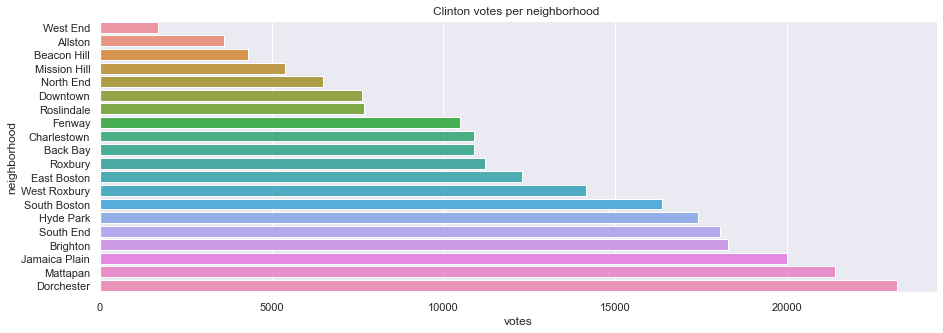

In [18]:
fig,axes = plt.subplots(figsize=(15,5),sharey=False)
sns.barplot(x='votes', y='neighborhood', data=C).set_title('Clinton votes per neighborhood ')

Text(0.5, 1.0, 'Trump votes per neighborhood ')

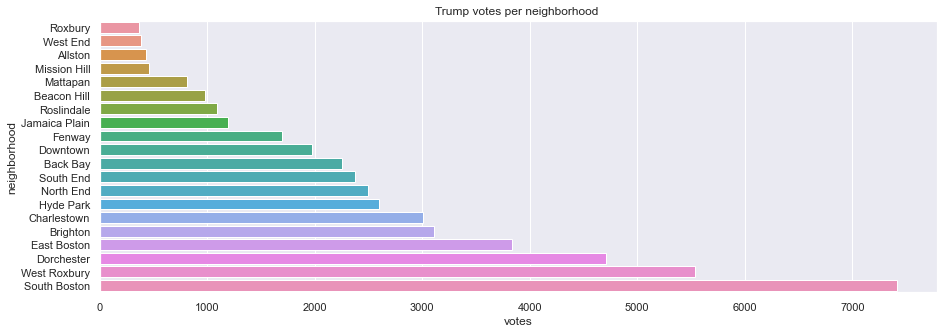

In [19]:
fig,axes = plt.subplots(figsize=(15,5),sharey=False)
sns.barplot(x='votes', y='neighborhood', data=T).set_title('Trump votes per neighborhood ')

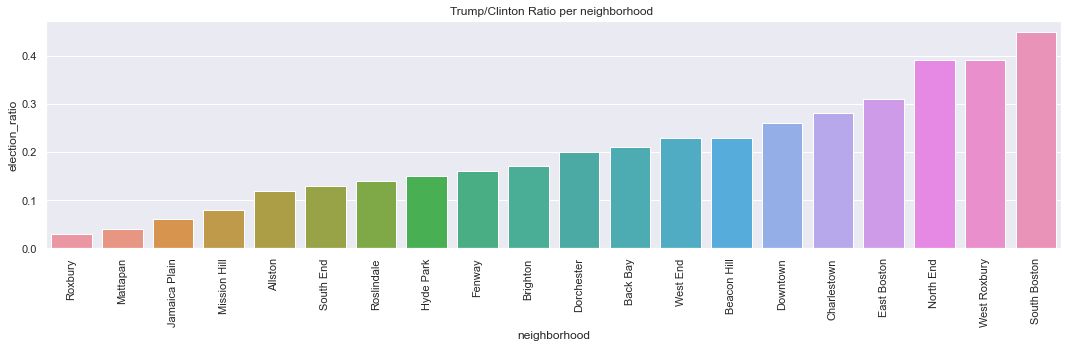

In [20]:
#getting the Ratio and plotting it 
result=pd.merge(T,C,on="neighborhood",suffixes=('_T','_C'))
result["election_ratio"]=round(result["votes_T"]/result["votes_C"],2)
#Bar plot 
fig,axes = plt.subplots(figsize=(15,5),sharey=False)
sns.barplot(x='neighborhood', y='election_ratio', data=result.sort_values(by=['election_ratio'])).set_title('Trump/Clinton Ratio per neighborhood ')
plt.xticks(rotation=90)
plt.tight_layout()

In [21]:
result

,neighborhood,district_T,votes_T,district_C,votes_C,election_ratio
0,Roxbury,B2,368,B2,11222,0.03
1,West End,A1,386,A1,1684,0.23
2,Allston,D14,427,D14,3613,0.12
3,Mission Hill,B2,457,B2,5404,0.08
4,Mattapan,B3,814,B3,21378,0.04
5,Beacon Hill,A1,975,A1,4308,0.23
6,Roslindale,E5,1088,E5,7687,0.14
7,Jamaica Plain,E13,1191,E13,19993,0.06
8,Fenway,D4,1699,D4,10468,0.16
9,Downtown,A1,1976,A1,7617,0.26


In [22]:
boston_crime_df = pd.read_csv('Data/tmpkxf1uea4.csv',encoding = 'unicode_escape')
boston_crime_df.head()

/Users/v608989/opt/anaconda3/envs/cs109a_3_7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,2,6,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,TESTTEST2,423,NaN,ASSAULT - AGGRAVATED,External,,0,2019-10-16 00:00:00,2019,10,Wednesday,0,NaN,RIVERVIEW DR,NaN,NaN,"(0.00000000, 0.00000000)"
1,S97333701,3301,NaN,VERBAL DISPUTE,C6,915,0,2020-07-18 14:34:00,2020,7,Saturday,14,NaN,MARY BOYLE WAY,42.330813,-71.051368,"(42.33081300, -71.05136800)"
2,S47513131,2647,NaN,THREATS TO DO BODILY HARM,E18,530,0,2020-06-24 10:15:00,2020,6,Wednesday,10,NaN,READVILLE ST,42.239491,-71.135954,"(42.23949100, -71.13595400)"
3,I92102201,3301,NaN,VERBAL DISPUTE,E13,583,0,2019-12-20 03:08:00,2019,12,Friday,3,NaN,DAY ST,42.325122,-71.107779,"(42.32512200, -71.10777900)"
4,I92097173,3115,NaN,INVESTIGATE PERSON,C11,355,0,2019-10-23 00:00:00,2019,10,Wednesday,0,NaN,GIBSON ST,42.297555,-71.059709,"(42.29755500, -71.05970900)"


In [23]:
# merging with Election data
boston_crime_df = pd.merge(boston_crime_df,result, left_on="DISTRICT", right_on="district_T")
boston_crime_df.drop(["district_T","votes_T","district_C","votes_C"],axis=1)
boston_crime_df.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,...,STREET,Lat,Long,Location,neighborhood,district_T,votes_T,district_C,votes_C,election_ratio
0,S97333701,3301,NaN,VERBAL DISPUTE,C6,915,0,2020-07-18 14:34:00,2020,7,...,MARY BOYLE WAY,42.330813,-71.051368,"(42.33081300, -71.05136800)",South Boston,C6,7414,C6,16367,0.45
1,I20210846,3201,NaN,PROPERTY - LOST/ MISSING,C6,206,0,2020-02-09 00:30:00,2020,2,...,SEAPORT BLVD,42.352756,-71.047481,"(42.35275600, -71.04748100)",South Boston,C6,7414,C6,16367,0.45
2,I20207883,3115,NaN,INVESTIGATE PERSON,C6,914,0,2020-04-18 17:11:00,2020,4,...,OLD COLONY AVE,42.325573,-71.052481,"(42.32557300, -71.05248100)",South Boston,C6,7414,C6,16367,0.45
3,I192078622,619,Larceny,LARCENY ALL OTHERS,C6,201,NaN,2019-09-29 03:04:00,2019,9,...,W BROADWAY,42.340070,-71.052794,"(42.34006986, -71.05279420)",South Boston,C6,7414,C6,16367,0.45
4,I192078606,3201,Property Lost,PROPERTY - LOST,C6,200,NaN,2019-09-29 02:21:00,2019,9,...,W BROADWAY,42.341288,-71.054679,"(42.34128751, -71.05467933)",South Boston,C6,7414,C6,16367,0.45


In [24]:
cols_needed = ['OFFENSE_DESCRIPTION', 'DISTRICT', 'OCCURRED_ON_DATE','YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'Lat', 'Long']
crimes1 = pd.DataFrame(boston_crime_df.copy()).drop(columns=boston_crime_df.columns.difference(cols_needed))

In [25]:
display(crimes1.isnull().sum())

OFFENSE_DESCRIPTION        0
DISTRICT                   0
OCCURRED_ON_DATE           0
YEAR                       0
MONTH                      0
DAY_OF_WEEK                0
HOUR                       0
Lat                    63682
Long                   63682
dtype: int64

In [26]:
# Analyzing the NaN values
crime_NaN= crimes1[crimes1.Lat.isnull()]
display(crime_NaN['OFFENSE_DESCRIPTION'].value_counts())

M/V - LEAVING SCENE - PROPERTY DAMAGE                                         4789
SICK/INJURED/MEDICAL - PERSON                                                 3012
ASSAULT SIMPLE - BATTERY                                                      2975
M/V ACCIDENT - PERSONAL INJURY                                                2967
M/V ACCIDENT - PROPERTY Â DAMAGE                                              2924
                                                                              ... 
MANSLAUGHTER - VEHICLE - NEGLIGENCE                                              1
HUMAN TRAFFICKING - COMMERCIAL SEX ACTS                                          1
FIREARM/WEAPON - ACCIDENTAL INJURY / DEATH                                       1
PRISONER - SUICIDE / SUICIDE ATTEMPT                                             1
RECOVERED - MV RECOVERED IN BOSTON (STOLEN IN BOSTON) MUST BE SUPPLEMENTAL       1
Name: OFFENSE_DESCRIPTION, Length: 208, dtype: int64

In [27]:
crimes_clean= crimes1[crimes1['Lat'].notna()]
len(crimes_clean)

904137

In [28]:
# how much District Nan after Lat and long clean up
display(crimes_clean.isnull().sum())

OFFENSE_DESCRIPTION    0
DISTRICT               0
OCCURRED_ON_DATE       0
YEAR                   0
MONTH                  0
DAY_OF_WEEK            0
HOUR                   0
Lat                    0
Long                   0
dtype: int64

In [29]:
# merging with Crime index
crime_violence_ind = pd.read_csv('Data/boston_crime_violence_ind.csv')
boston_crime_df = pd.merge(crimes_clean,crime_violence_ind, left_on="OFFENSE_DESCRIPTION", right_on="OFFENSE_DESCRIPTION")
boston_crime_df.head()

,OFFENSE_DESCRIPTION,DISTRICT,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,Lat,Long,VIOLENT_CRIME,OFFENSE_TYPE
0,VERBAL DISPUTE,C6,2020-07-18 14:34:00,2020,7,Saturday,14,42.330813,-71.051368,0,Other
1,VERBAL DISPUTE,C6,2019-09-19 16:14:00,2019,9,Thursday,16,42.327204,-71.053189,0,Other
2,VERBAL DISPUTE,C6,2019-09-18 23:35:00,2019,9,Wednesday,23,42.317794,-71.042110,0,Other
3,VERBAL DISPUTE,C6,2019-09-18 09:41:00,2019,9,Wednesday,9,42.330692,-71.058261,0,Other
4,VERBAL DISPUTE,C6,2019-09-11 17:01:00,2019,9,Wednesday,17,42.330116,-71.050728,0,Other


In [30]:
#droping crimes with Lat= -1, and split columns based on Date and Time 
boston_crime_df.drop(boston_crime_df[boston_crime_df['Lat'] == -1].index, inplace = True)
boston_crime_df[['DATE','TIME']] = boston_crime_df['OCCURRED_ON_DATE'].str.split(" ",expand=True)
boston_crime_df.head()

,OFFENSE_DESCRIPTION,DISTRICT,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,Lat,Long,VIOLENT_CRIME,OFFENSE_TYPE,DATE,TIME
0,VERBAL DISPUTE,C6,2020-07-18 14:34:00,2020,7,Saturday,14,42.330813,-71.051368,0,Other,2020-07-18,14:34:00
1,VERBAL DISPUTE,C6,2019-09-19 16:14:00,2019,9,Thursday,16,42.327204,-71.053189,0,Other,2019-09-19,16:14:00
2,VERBAL DISPUTE,C6,2019-09-18 23:35:00,2019,9,Wednesday,23,42.317794,-71.042110,0,Other,2019-09-18,23:35:00
3,VERBAL DISPUTE,C6,2019-09-18 09:41:00,2019,9,Wednesday,9,42.330692,-71.058261,0,Other,2019-09-18,09:41:00
4,VERBAL DISPUTE,C6,2019-09-11 17:01:00,2019,9,Wednesday,17,42.330116,-71.050728,0,Other,2019-09-11,17:01:00


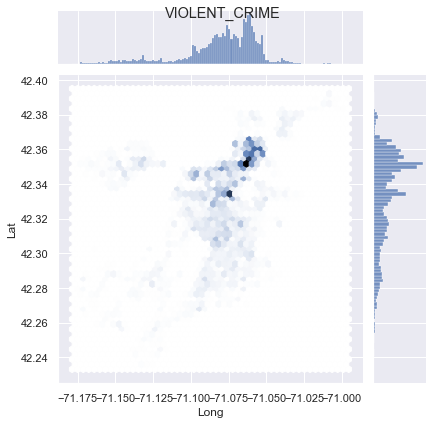

In [31]:
# showing where most of the violent crime hapening, Latitude is the Y axis, longitude is the X axis.
Violent =boston_crime_df.loc[boston_crime_df['VIOLENT_CRIME']== 1]
sns.jointplot(x='Long',y='Lat',data=Violent,kind='hex')
plt.suptitle('VIOLENT_CRIME')
plt.show()

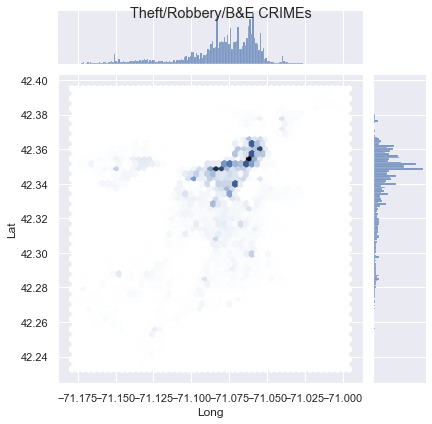

In [32]:
# Showing where most of the theft is hapening, 
Violent =boston_crime_df.loc[boston_crime_df['OFFENSE_TYPE']== 'Theft/Robbery/B&E']
sns.jointplot(x='Long',y='Lat',data=Violent,kind='hex')
plt.suptitle('Theft/Robbery/B&E CRIMEs ')
plt.show()

- Boston Crime rate to Light poles location  

In [33]:
# https://data.boston.gov/dataset/streetlight-locations
streetlights = pd.read_csv('Data/streetlight-locations.csv')

In [34]:
streetlights.head()

,the_geom,OBJECTID,TYPE,Lat,Long
0,POINT (-71.0760443807948 42.35315925057316),1,LIGHT,42.353159,-71.076044
1,POINT (-71.07538171240694 42.353347768071195),2,LIGHT,42.353348,-71.075382
2,POINT (-71.07477488057383 42.35352052068278),3,LIGHT,42.353521,-71.074775
3,POINT (-71.07440373484715 42.3535558201314),4,LIGHT,42.353556,-71.074404
4,POINT (-71.07362079549182 42.35381056415504),5,LIGHT,42.353811,-71.073621


In [35]:
# used the haversine function to calculate Pole distances based on latitude/longitude coordinates as reference in https://rosettacode.org/wiki/Haversine_formula#Python
from math import radians, sin, cos, sqrt, asin
 
def haversine_np(lat1, lat2, lon1, lon2):
    R = 6372.8*1000  # Earth radius in meters

    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    lon1 = np.radians(lon1)
    lon2 = np.radians(lon2)

    dLat = lat2 - lat1
    dLon = lon2 - lon1

    a = np.sin(dLat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dLon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R*c

In [36]:
di=haversine_np(42.297555, streetlights["Lat"], -71.059709, streetlights["Long"])
di.min()

23.42932237266259

In [37]:
boston_crime_df.head()

,OFFENSE_DESCRIPTION,DISTRICT,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,Lat,Long,VIOLENT_CRIME,OFFENSE_TYPE,DATE,TIME
0,VERBAL DISPUTE,C6,2020-07-18 14:34:00,2020,7,Saturday,14,42.330813,-71.051368,0,Other,2020-07-18,14:34:00
1,VERBAL DISPUTE,C6,2019-09-19 16:14:00,2019,9,Thursday,16,42.327204,-71.053189,0,Other,2019-09-19,16:14:00
2,VERBAL DISPUTE,C6,2019-09-18 23:35:00,2019,9,Wednesday,23,42.317794,-71.042110,0,Other,2019-09-18,23:35:00
3,VERBAL DISPUTE,C6,2019-09-18 09:41:00,2019,9,Wednesday,9,42.330692,-71.058261,0,Other,2019-09-18,09:41:00
4,VERBAL DISPUTE,C6,2019-09-11 17:01:00,2019,9,Wednesday,17,42.330116,-71.050728,0,Other,2019-09-11,17:01:00


In [64]:
! pip install tqdm

In [38]:
# Start Timer
start = time.time()

#calculating For each crime in the crime df the minimum distances to all streetlights in boston 
#Blocks in Boston are very much like NYC, longer in one direction than another.The standard block in Manhattan is about 264 by 900 feet (80 m × 274 m)

#distances = np.zeros((len(boston_crime_df)))
light_density = np.zeros((len(boston_crime_df)))

for i in range(len(boston_crime_df)):
    distance = haversine_np(boston_crime_df["Lat"].iloc[i], streetlights["Lat"], boston_crime_df["Long"].iloc[i], streetlights["Long"])
    #distances[i] = distance.min()
    index_one_block = np.where(distance<80)
    light_density[i] = len(streetlights[['Lat','Long']].iloc[index_one_block])
# Stop Timer
end = time.time()
elapsed_light_density = end - start

In [39]:
boston_crime_df['Streetlight_density'] = light_density

In [40]:
#crimes1['Streetlight_distance'].describe()

In [41]:
#crimes1.head()

- Boston Crime rate to police, college and hospitals location 

In [42]:
#https://data.boston.gov/dataset/hospitals1
hospitals = pd.read_csv('Data/Hospitals.csv')
#https://data.boston.gov/dataset/colleges-and-universities1
univerities = pd.read_csv('Data/Colleges_and_Universities.csv') 
#https://data.boston.gov/dataset/boston-police-stations1
boston_police = pd.read_csv('Data/Boston_Police_Stations_loc.csv') 

In [43]:
hospitals.head()

,X,Y,OBJECTID,Census_Tra,Name,Address,City,Zipcode,Statea,Contact,PhoneNumbe,Latitude,Longitude,Comment_,Primary_Alt,Alternative_Name,DailyAvg
0,761038.115649,2.940335e+06,1,0,Arbour Hospital,"49 Robinwood Ave, Boston, MA",,2130,,ARBOUR HOSP INC MASS CORP,617-522-4400,42.315770,-71.112250,,Primary,NaN,NaN
1,768907.965723,2.945461e+06,2,0,Franciscan Children's Hospital & Rehab Center,"30 Warren St, Boston, MA",,2119,,RYAN ALBERTHA K TS,(617) 254-3800,42.329740,-71.083060,,Primary,NaN,NaN
2,756069.115416,2.933355e+06,3,0,Hebrew Rehabilitation Center,"1200 Centre St, Boston, MA",,2131,,HEBREW REHABILITATION CNTR,617-363-8000,42.296681,-71.130734,,Primary,NaN,NaN
3,766389.704027,2.941384e+06,4,0,Jewish Memorial Hospital & Radius Hospital,"59 Townsend St, Boston, MA",,2119,,RADIUS-FA LTCH REALTY LLC,617-522-8110,42.318585,-71.092445,,Primary,NaN,NaN
4,752985.350258,2.951533e+06,5,0,Kindred Hospital,"1515 Commonwealth Ave, Boston, MA",,2135,,VENTAS LPS,617-254-1100,42.346600,-71.141850,,Primary,NaN,NaN


In [44]:

distances_police = np.zeros((len(boston_crime_df)))
distances_uni = np.zeros((len(boston_crime_df)))
distances_hospitals = np.zeros((len(boston_crime_df)))

for i in range(len(boston_crime_df)):
    distances_police[i] = haversine_np(boston_crime_df["Lat"].iloc[i], boston_police["Lat"], boston_crime_df["Long"].iloc[i], boston_police["Long"]).min()
    distances_uni[i] = haversine_np(boston_crime_df["Lat"].iloc[i], univerities["Latitude"], boston_crime_df["Long"].iloc[i], univerities["Longitude"]).min()
    distances_hospitals[i] = haversine_np(boston_crime_df["Lat"].iloc[i], hospitals["Latitude"], boston_crime_df["Long"].iloc[i], hospitals["Longitude"]).min()

In [45]:
boston_crime_df['Police_Station_Distance'] = distances_police
boston_crime_df['Hospitals_Distance'] = distances_hospitals
boston_crime_df['College_Univ_Distance'] = distances_uni

- Boston Crime rate to Weather changes 

In [46]:
boston_weather = pd.read_csv('Data/Weather_history.csv',encoding = 'unicode_escape')
boston_weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,AWND_ATTRIBUTES,FMTM,FMTM_ATTRIBUTES,...,WT17,WT17_ATTRIBUTES,WT18,WT18_ATTRIBUTES,WT19,WT19_ATTRIBUTES,WT21,WT21_ATTRIBUTES,WT22,WT22_ATTRIBUTES
0,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,2004-01-01,12.75,",,X",1514.0,",,X",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,2004-01-02,4.47,",,X",938.0,",,X",...,NaN,NaN,1.0,",,0",NaN,NaN,NaN,NaN,NaN,NaN
2,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,2004-01-03,3.58,",,X",2309.0,",,X",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,2004-01-04,8.72,",,X",2352.0,",,X",...,NaN,NaN,1.0,",,0",NaN,NaN,NaN,NaN,NaN,NaN
4,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,2004-01-05,12.30,",,X",1803.0,",,X",...,1.0,",,X",NaN,NaN,1.0,",,X",NaN,NaN,NaN,NaN


In [47]:
boston_weather.columns

Index(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'AWND',
       'AWND_ATTRIBUTES', 'FMTM', 'FMTM_ATTRIBUTES', 'PGTM', 'PGTM_ATTRIBUTES',
       'PRCP', 'PRCP_ATTRIBUTES', 'SNOW', 'SNOW_ATTRIBUTES', 'SNWD',
       'SNWD_ATTRIBUTES', 'TAVG', 'TAVG_ATTRIBUTES', 'TMAX', 'TMAX_ATTRIBUTES',
       'TMIN', 'TMIN_ATTRIBUTES', 'TSUN', 'TSUN_ATTRIBUTES', 'WDF2',
       'WDF2_ATTRIBUTES', 'WDF5', 'WDF5_ATTRIBUTES', 'WESD', 'WESD_ATTRIBUTES',
       'WSF2', 'WSF2_ATTRIBUTES', 'WSF5', 'WSF5_ATTRIBUTES', 'WT01',
       'WT01_ATTRIBUTES', 'WT02', 'WT02_ATTRIBUTES', 'WT03', 'WT03_ATTRIBUTES',
       'WT04', 'WT04_ATTRIBUTES', 'WT05', 'WT05_ATTRIBUTES', 'WT06',
       'WT06_ATTRIBUTES', 'WT07', 'WT07_ATTRIBUTES', 'WT08', 'WT08_ATTRIBUTES',
       'WT09', 'WT09_ATTRIBUTES', 'WT11', 'WT11_ATTRIBUTES', 'WT13',
       'WT13_ATTRIBUTES', 'WT14', 'WT14_ATTRIBUTES', 'WT15', 'WT15_ATTRIBUTES',
       'WT16', 'WT16_ATTRIBUTES', 'WT17', 'WT17_ATTRIBUTES', 'WT18',
       'WT18_ATTRIBUTES', 

In [48]:
#When we talk about precipitation, we are talking about water that is falling out of the sky, this could be rain, drizzle, snow, sleet, hail or something rarer!
cols_needed = ['DATE','PRCP','SNOW']
boston_weather_df = pd.DataFrame(boston_weather.copy()).drop(columns=boston_weather.columns.difference(cols_needed))
boston_weather_df.head()

,DATE,PRCP,SNOW
0,2004-01-01,0.00,0.0
1,2004-01-02,0.06,0.3
2,2004-01-03,0.16,0.0
3,2004-01-04,0.17,0.0
4,2004-01-05,0.29,0.0


In [49]:
boston_crime_df = pd.merge(boston_crime_df,boston_weather_df, left_on=['DATE'], right_on=['DATE'])
boston_crime_df.head()

,OFFENSE_DESCRIPTION,DISTRICT,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,Lat,Long,VIOLENT_CRIME,OFFENSE_TYPE,DATE,TIME,Streetlight_density,Police_Station_Distance,Hospitals_Distance,College_Univ_Distance,PRCP,SNOW
0,VERBAL DISPUTE,C6,2020-07-18 14:34:00,2020,7,Saturday,14,42.330813,-71.051368,0,Other,2020-07-18,14:34:00,15.0,1189.301193,1746.645888,1726.855499,0.0,0.0
1,VERBAL DISPUTE,E13,2020-07-18 11:16:00,2020,7,Saturday,11,42.314333,-71.097914,0,Other,2020-07-18,11:16:00,24.0,754.880893,652.705979,1669.434788,0.0,0.0
2,VERBAL DISPUTE,C11,2020-07-18 17:45:00,2020,7,Saturday,17,42.284398,-71.064683,0,Other,2020-07-18,17:45:00,20.0,1587.437514,779.885128,780.049628,0.0,0.0
3,VERBAL DISPUTE,C11,2020-07-18 14:25:00,2020,7,Saturday,14,42.299999,-71.053836,0,Other,2020-07-18,14:25:00,2.0,484.362360,2693.577200,1951.543201,0.0,0.0
4,VERBAL DISPUTE,C11,2020-07-18 12:13:00,2020,7,Saturday,12,42.300706,-71.068583,0,Other,2020-07-18,12:13:00,17.0,833.071029,2600.218236,2608.333480,0.0,0.0


- Boston Crime rate to night/day changes 

In [50]:
#adding a binary 'NIGHT' feature, categorizing crimes occuring between 8pm and 4am as night-time crimes:
boston_crime_df['NIGHT'] = 0
boston_crime_df['NIGHT'][(boston_crime_df['HOUR'] >= 20)] = 1
boston_crime_df['NIGHT'][(boston_crime_df['HOUR'] <= 5)] = 1

/Users/v608989/opt/anaconda3/envs/cs109a_3_7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/v608989/opt/anaconda3/envs/cs109a_3_7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [54]:
boston_crime_df.head()

,OFFENSE_DESCRIPTION,DISTRICT,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,Lat,Long,VIOLENT_CRIME,OFFENSE_TYPE,DATE,TIME,Streetlight_density,Police_Station_Distance,Hospitals_Distance,College_Univ_Distance,PRCP,SNOW,NIGHT
0,VERBAL DISPUTE,C6,2020-07-18 14:34:00,2020,7,Saturday,14,42.330813,-71.051368,0,Other,2020-07-18,14:34:00,15.0,1189.301193,1746.645888,1726.855499,0.0,0.0,0
1,VERBAL DISPUTE,E13,2020-07-18 11:16:00,2020,7,Saturday,11,42.314333,-71.097914,0,Other,2020-07-18,11:16:00,24.0,754.880893,652.705979,1669.434788,0.0,0.0,0
2,VERBAL DISPUTE,C11,2020-07-18 17:45:00,2020,7,Saturday,17,42.284398,-71.064683,0,Other,2020-07-18,17:45:00,20.0,1587.437514,779.885128,780.049628,0.0,0.0,0
3,VERBAL DISPUTE,C11,2020-07-18 14:25:00,2020,7,Saturday,14,42.299999,-71.053836,0,Other,2020-07-18,14:25:00,2.0,484.362360,2693.577200,1951.543201,0.0,0.0,0
4,VERBAL DISPUTE,C11,2020-07-18 12:13:00,2020,7,Saturday,12,42.300706,-71.068583,0,Other,2020-07-18,12:13:00,17.0,833.071029,2600.218236,2608.333480,0.0,0.0,0


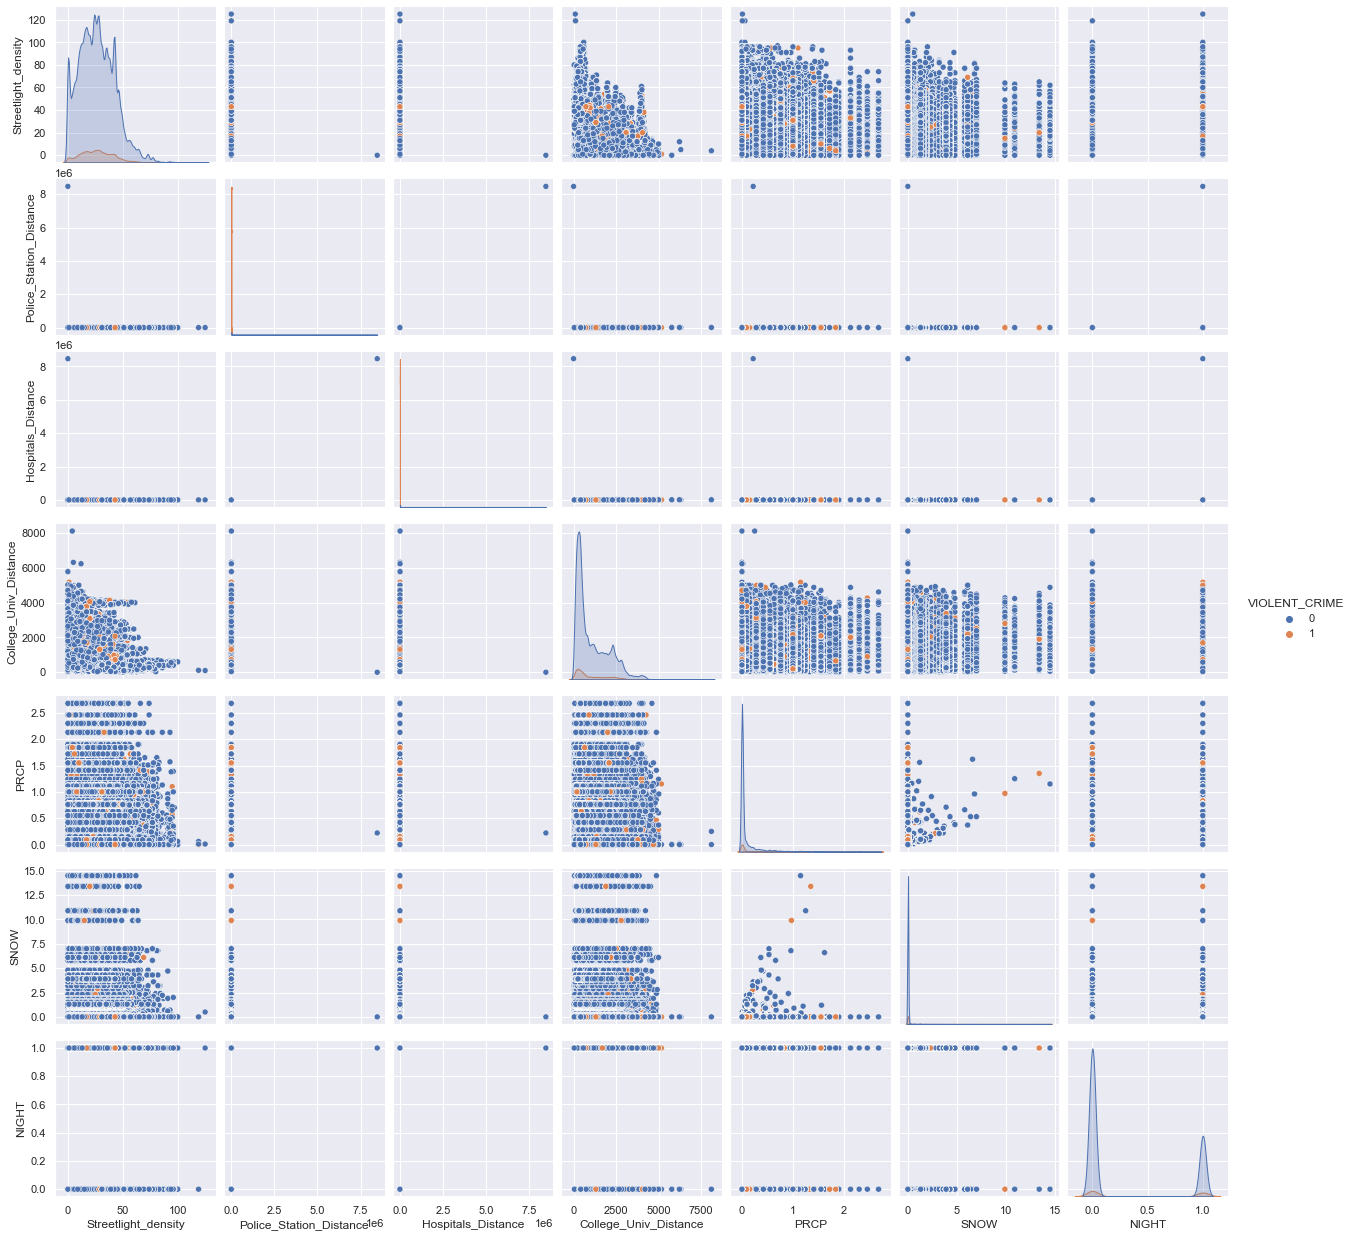

In [55]:
sns.pairplot(boston_crime_df[['Streetlight_density','Police_Station_Distance','Hospitals_Distance','College_Univ_Distance','PRCP','SNOW','NIGHT','VIOLENT_CRIME','OFFENSE_TYPE']])
plt.show()

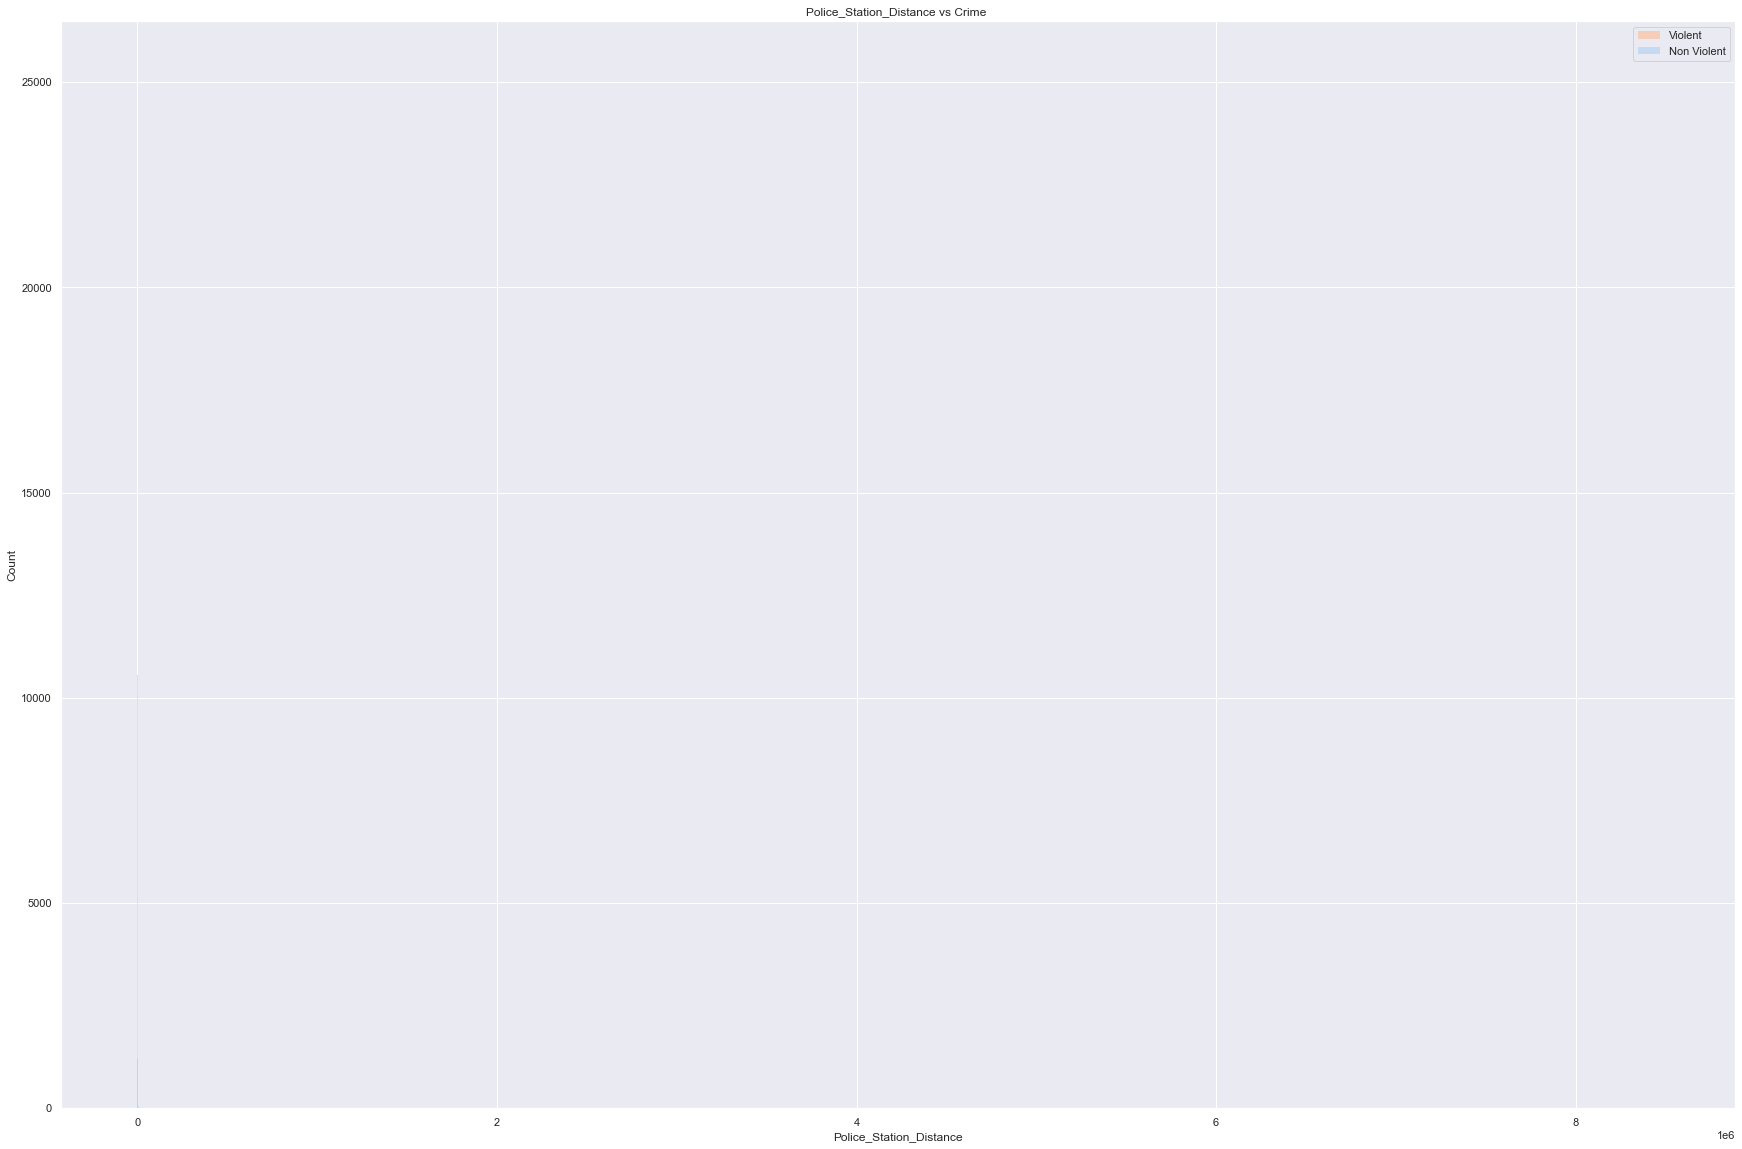

In [57]:
fig,axes = plt.subplots(figsize=(10,10),sharey=False)

sns.histplot(x="Police_Station_Distance",hue="VIOLENT_CRIME",palette="pastel", edgecolor=".1",data=boston_crime_df)
new_labels = ['Violent', 'Non Violent']
axes.legend(new_labels)
axes.title.set_text("Police_Station_Distance vs Crime ")

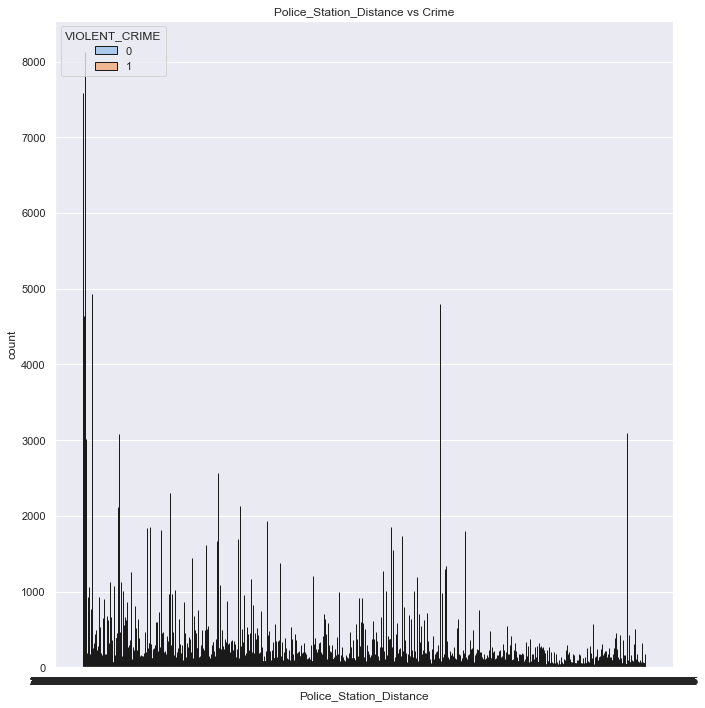

In [66]:
from tqdm.notebook import trange
# Start Timer
start = time.time()

fig,axes = plt.subplots(figsize=(10,10),sharey=False)
sns.countplot(x="Police_Station_Distance", hue="VIOLENT_CRIME", color='b', data=boston_crime_df,edgecolor=".1",palette="pastel",ax=axes)
# new_labels = ['Admited', 'Not admitted']
# axes.legend(new_labels)
axes.title.set_text("Police_Station_Distance vs Crime" )
plt.plot()
fig.tight_layout()
# Stop Timer
end = time.time()
elapsed_ploting = end - start